## Introdução

Este Jupyter Notebook faz parte de um projeto de aplicação prática em Visão Computacional e Redes Neurais Convolucionais (CNN).

---
### Problema

Dado uma imagem, o modelo deve responder:  
**Essa imagem representa um gato ou um cachorro?**

Para isso, utilizaremos um conjunto de imagens previamente rotuladas de gatos e cachorros, e aplicaremos uma abordagem de **aprendizado supervisionado**. Durante o treinamento, o modelo aprenderá a distinguir características visuais específicas que o ajudarão a identificar corretamente novas imagens nunca vistas.

---

### Estratégia

A arquitetura escolhida para resolver esse problema é uma **Rede Neural Convolucional (CNN)**. Esse tipo de rede é especialmente eficaz para tarefas de classificação de imagens, pois é capaz de extrair automaticamente padrões visuais relevantes através de operações de convolução e pooling.

Durante o treinamento, a CNN irá aprender, por exemplo:

- A presença de bigodes ou orelhas pontudas (características comuns em gatos);
- Focinho largo, olhos grandes ou orelhas caídas (características comuns em cachorros).

---

### Solução Proposta

- Utilizar a biblioteca `datasets` da Hugging Face para carregar o dataset **`microsoft/cats_vs_dogs`**.
- Aplicar **pré-processamento** de redimensionamento e normalização nas imagens.
- Dividir os dados em treino, validação e teste.
- Construir uma CNN utilizando **Keras/TensorFlow**.
- Treinar, avaliar e salvar o modelo.
- Analisar a evolução do desempenho ao longo das épocas.

---

Este notebook serve como um exemplo prático e educativo de como podemos aplicar Deep Learning em problemas de classificação binária de imagens com alta eficiência.

### 1. Carregamento do Dataset

Utilizamos o dataset microsoft/cats_vs_dogs da Hugging Face.
Ele já vem rotulado (labels: 0 = gato, 1 = cachorro) e pronto para ser dividido e pré-processado.

In [4]:
from datasets import load_dataset

# Carrega o dataset da Hugging Face
ds = load_dataset("microsoft/cats_vs_dogs")

# Visualiza a estrutura do dataset
ds

c:\Users\matma\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

### 2. Pré-processamento das Imagens

As imagens foram convertidas para RGB, redimensionadas para 128x128 e normalizadas ([0, 1]) para facilitar o aprendizado da rede.

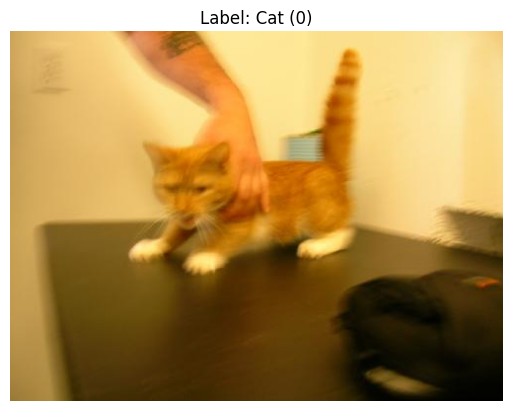

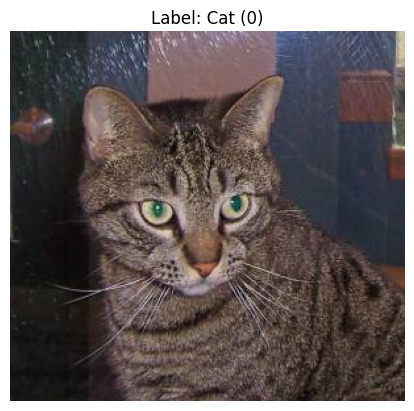

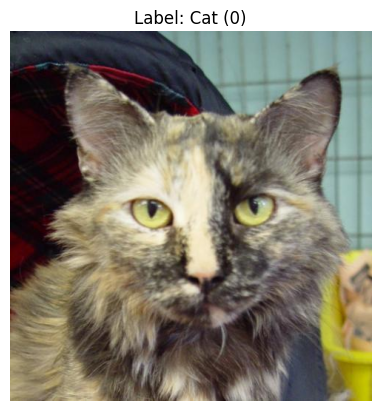

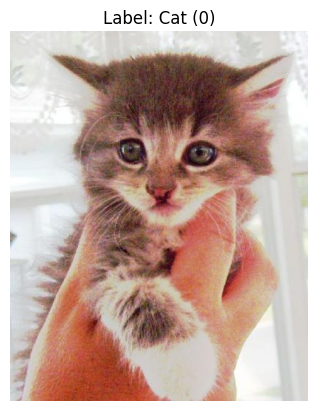

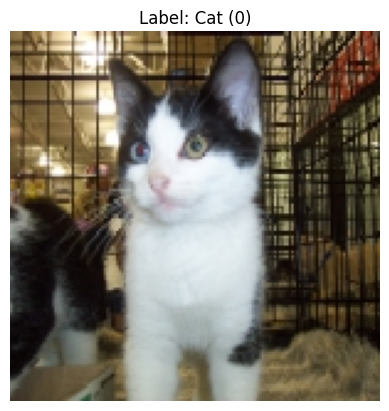

In [5]:
import matplotlib.pyplot as plt

# Função para exibir imagem com rótulo
def show_image(index):
    sample = ds["train"][index]
    img = sample["image"]
    label = sample["labels"]
    
    label_str = "Cat" if label == 0 else "Dog"
    
    plt.imshow(img)
    plt.title(f"Label: {label_str} ({label})")
    plt.axis("off")
    plt.show()

# Exibir 5 imagens
for i in range(5):
    show_image(i)

### 3. Divisão do Conjunto de Dados

Dividimos o dataset da seguinte forma:

80% para treino

10% para validação

10% para teste

Usamos a função .train_test_split() do próprio Hugging Face para isso.

In [6]:
# Divide o dataset original (100%) em treino (80%) e temporário (20%)
split = ds["train"].train_test_split(test_size=0.2, seed=42)

# Divide os 20% restantes em validação (10%) e teste (10%)
val_test_split = split["test"].train_test_split(test_size=0.5, seed=42)

# Monta o dataset final com as três divisões
dataset = {
    "train": split["train"],
    "validation": val_test_split["train"],
    "test": val_test_split["test"]
}

# Verifica quantas imagens em cada divisão
for key in dataset:
    print(f"{key}: {len(dataset[key])} imagens")

train: 18728 imagens
validation: 2341 imagens
test: 2341 imagens


### 4. Arquitetura da Rede Neural Convolucional (CNN)

A arquitetura utilizada foi a seguinte:

Conv2D(32) + MaxPooling

Conv2D(64) + MaxPooling

Conv2D(128) + MaxPooling

Flatten + Dense(128)

Dropout(0.5)

Dense(1, activation='sigmoid') ← saída binária

O modelo foi compilado com binary_crossentropy e otimizado com adam.

**Preparar os dados para treino**

In [7]:
def to_tuple(example):
    return example["image"], example["label"]

In [8]:
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Transforma as imagens em arrays normalizados e reestruturados
def transform(example):
    image = example["image"].convert("RGB")  # força RGB
    image = image.resize(IMG_SIZE)
    image = tf.keras.utils.img_to_array(image) / 255.0
    return {
        "image": image,
        "label": example["labels"]
    }

# Aplica a transformação no dataset Hugging Face
train_dataset = dataset["train"].map(transform)
val_dataset = dataset["validation"].map(transform)
test_dataset = dataset["test"].map(transform)

In [9]:
train_dataset = dataset["train"].map(transform)
val_dataset = dataset["validation"].map(transform)
test_dataset = dataset["test"].map(transform)

In [10]:
# Função que converte os exemplos para tuplas (imagem, rótulo)
def to_tuple(example):
    return example["image"], example["label"]

# Criação segura dos datasets no formato esperado pelo TensorFlow
train_tf = tf.data.Dataset.from_generator(lambda: (to_tuple(x) for x in train_dataset),
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
)

val_tf = tf.data.Dataset.from_generator(lambda: (to_tuple(x) for x in val_dataset),
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
)

test_tf = tf.data.Dataset.from_generator(lambda: (to_tuple(x) for x in test_dataset),
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
)

# Organiza em batches
train_tf = train_tf.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_tf = val_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_tf = test_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


### Criar o modelo da Rede Neural Convolucional (CNN)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Arquitetura da CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # 1 saída para classificação binária (cat vs dog)
])

c:\Users\matma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [13]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Treinamento do Modelo

O modelo foi treinado por 5 épocas. A acurácia aumentou significativamente nas primeiras épocas e estabilizou por volta de 86% no treino e ~81% na validação.

Gráfico da evolução da acurácia:

In [15]:
# Treinamento do modelo
history = model.fit(
    train_tf,
    validation_data=val_tf,
    epochs=5  # você pode testar com 5 primeiro, e depois aumentar se quiser
)

Epoch 1/5
    586/Unknown 2012s 3s/step - accuracy: 0.6385 - loss: 0.6351

c:\Users\matma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


586/586 ━━━━━━━━━━━━━━━━━━━━ 2253s 4s/step - accuracy: 0.6386 - loss: 0.6350 - val_accuracy: 0.6822 - val_loss: 0.5704
Epoch 2/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 2149s 4s/step - accuracy: 0.7478 - loss: 0.5112 - val_accuracy: 0.7676 - val_loss: 0.4866
Epoch 3/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 2150s 4s/step - accuracy: 0.7967 - loss: 0.4419 - val_accuracy: 0.8185 - val_loss: 0.3993
Epoch 4/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 2128s 3s/step - accuracy: 0.8329 - loss: 0.3782 - val_accuracy: 0.8197 - val_loss: 0.4022
Epoch 5/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 2153s 4s/step - accuracy: 0.8606 - loss: 0.3160 - val_accuracy: 0.8172 - val_loss: 0.4027


**Gráfico da evolução da acurácia:**

O gráfico abaixo mostra a **evolução da acurácia** durante as 5 épocas de treinamento, tanto no conjunto de treino quanto no conjunto de validação:

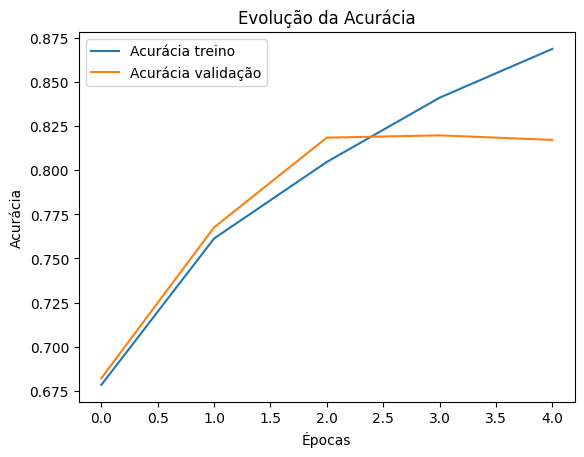

In [16]:
import matplotlib.pyplot as plt

# Visualizar perda e acurácia
plt.plot(history.history['accuracy'], label='Acurácia treino')
plt.plot(history.history['val_accuracy'], label='Acurácia validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Evolução da Acurácia')
plt.show()

### 6. Avaliação do Modelo no Conjunto de Teste

Após o treinamento, o modelo foi avaliado no conjunto de **teste**, obtendo os seguintes resultados:

Acurácia no teste: 83,26%

Perda no teste: 0.3893

In [17]:
# Avaliação do modelo no dataset de teste
test_loss, test_accuracy = model.evaluate(test_tf)
print(f'\nAcurácia no teste: {test_accuracy:.4f}')
print(f'Perda no teste: {test_loss:.4f}')

74/74 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.8198 - loss: 0.3956

Acurácia no teste: 0.8326
Perda no teste: 0.3893


###  7. Salvamento do Modelo

**O modelo final foi salvo para reutilização futura:**

In [ ]:
model.save("modelo_gatos_cachorros.h5")

(Opcional) Para carregar depois:

In [ ]:
from tensorflow.keras.models import load_model

modelo_carregado = load_model("modelo_gatos_cachorros.h5")

### 8. Conclusão

Este projeto demonstrou como redes neurais convolucionais (CNNs) podem ser aplicadas com eficácia em tarefas de classificação de imagens. Utilizando o dataset "Cats vs Dogs" da Microsoft, conseguimos treinar um modelo simples, porém eficiente, que alcançou os seguintes resultados:

- **Acurácia final no conjunto de teste:** 83,26%
- **Perda (loss) no teste:** 0.3893

A evolução da acurácia nas épocas mostra um bom aprendizado por parte do modelo, com indícios de generalização adequada, já que a acurácia de validação se manteve estável e próxima da de treino. Isso reforça a robustez do modelo desenvolvido, mesmo com uma arquitetura relativamente simples.

Além disso, o uso das bibliotecas Hugging Face Datasets, TensorFlow e Keras permitiu uma implementação moderna, com código limpo, reutilizável e pronto para ser expandido.
